In [1]:
# importing the libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go

# importing the datasets
training_data  = pd.read_csv('data/Train_data.csv')
test_data = pd.read_csv('data/Test_data.csv')

## Preprocessing

In [2]:
# checking the shape of the datasets
print(training_data.shape)
print(test_data.shape)

(25192, 42)
(22544, 41)


In [3]:
# checking null values
print(training_data.isnull().sum().sum()) # 0
print('------------------')
print(test_data.isnull().sum().sum()) # 0

0
------------------
0


In [4]:
# checking duplicates
print(f"Number of duplicate rows: {training_data.duplicated().sum()}")

Number of duplicate rows: 0


In [5]:
# checking the unique values
print(training_data.nunique())

duration                        758
protocol_type                     3
service                          66
flag                             11
src_bytes                      1665
dst_bytes                      3922
land                              2
wrong_fragment                    3
urgent                            2
hot                              22
num_failed_logins                 5
logged_in                         2
num_compromised                  28
root_shell                        2
su_attempted                      3
num_root                         28
num_file_creations               20
num_shells                        2
num_access_files                  7
num_outbound_cmds                 1
is_host_login                     1
is_guest_login                    2
count                           466
srv_count                       414
serror_rate                      70
srv_serror_rate                  56
rerror_rate                      72
srv_rerror_rate             

In [6]:
# extracting categorical attributes 
cate_training = training_data.select_dtypes(include=['object'])

# categorical features unique values
for col in cate_training.columns:
    print(col,':', cate_training[col].unique())

protocol_type : ['tcp' 'udp' 'icmp']
service : ['ftp_data' 'other' 'private' 'http' 'remote_job' 'name' 'netbios_ns'
 'eco_i' 'mtp' 'telnet' 'finger' 'domain_u' 'supdup' 'uucp_path' 'Z39_50'
 'smtp' 'csnet_ns' 'uucp' 'netbios_dgm' 'urp_i' 'auth' 'domain' 'ftp'
 'bgp' 'ldap' 'ecr_i' 'gopher' 'vmnet' 'systat' 'http_443' 'efs' 'whois'
 'imap4' 'iso_tsap' 'echo' 'klogin' 'link' 'sunrpc' 'login' 'kshell'
 'sql_net' 'time' 'hostnames' 'exec' 'ntp_u' 'discard' 'nntp' 'courier'
 'ctf' 'ssh' 'daytime' 'shell' 'netstat' 'pop_3' 'nnsp' 'IRC' 'pop_2'
 'printer' 'tim_i' 'pm_dump' 'red_i' 'netbios_ssn' 'rje' 'X11' 'urh_i'
 'http_8001']
flag : ['SF' 'S0' 'REJ' 'RSTR' 'SH' 'RSTO' 'S1' 'RSTOS0' 'S3' 'S2' 'OTH']
class : ['normal' 'anomaly']


In [7]:
# dropping the columns which are redundant 
training_data.drop(['num_outbound_cmds'], axis=1, inplace=True)

normal     13449
anomaly    11743
Name: class, dtype: int64


<AxesSubplot: xlabel='class', ylabel='count'>

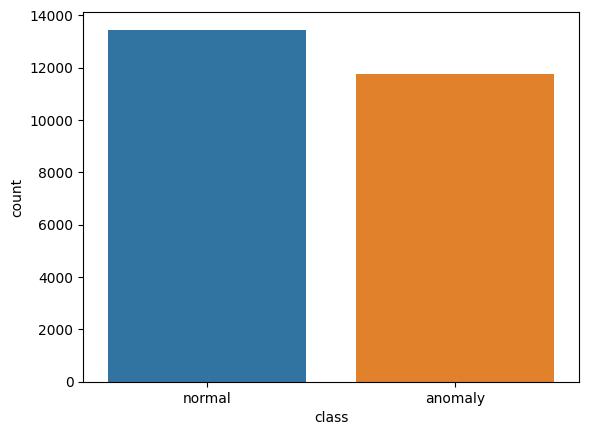

In [8]:
# class distribution
print(training_data['class'].value_counts())
sns.countplot(x=training_data['class'])

/tmp/ipykernel_18013/964067400.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(training_data.corr(), annot=True)


<AxesSubplot: >

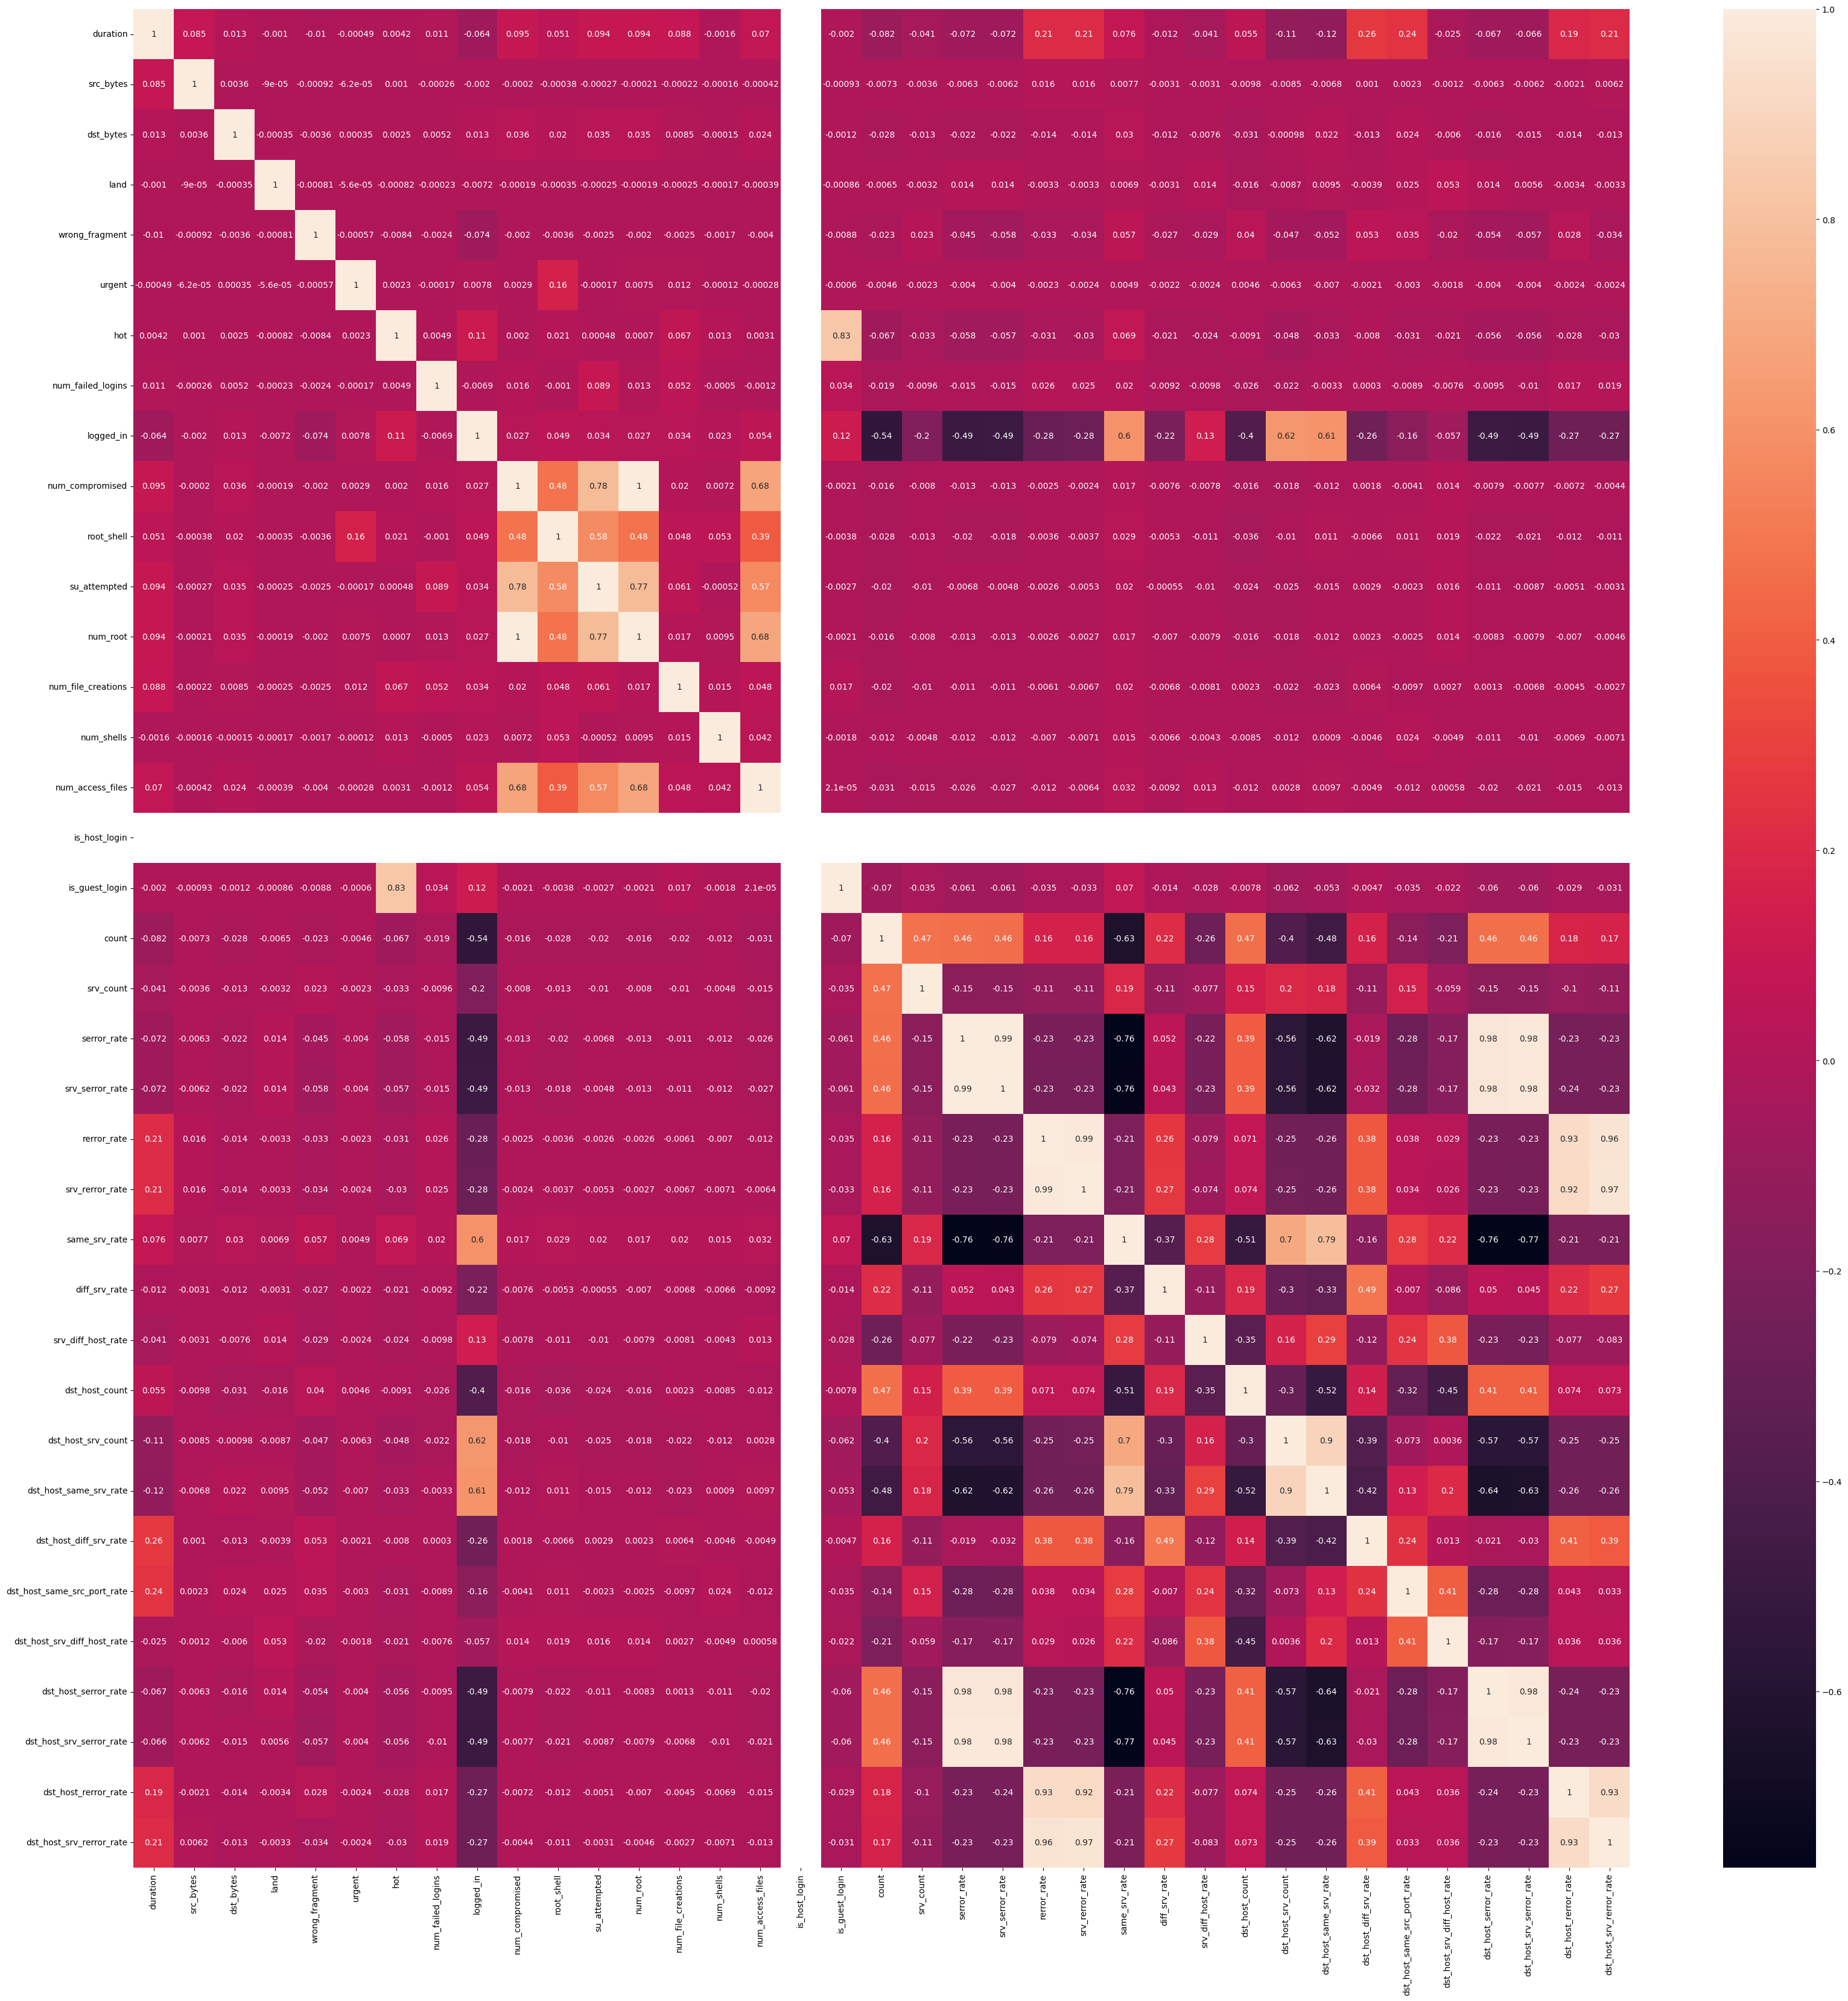

In [9]:
# heatmap
plt.figure(figsize=(40, 40))
sns.heatmap(training_data.corr(), annot=True)

### Normalization & Standardization

#### Numerical Features

In [10]:
scaler = StandardScaler()

# extracting numerical attributes and scaling it to have zero mean and unit variance  
columns = training_data.select_dtypes(include=['float64','int64']).columns
sc_training_data = scaler.fit_transform(training_data.select_dtypes(include=['float64','int64']))

# turning the result back to a dataframe
sc_training_df = pd.DataFrame(sc_training_data, columns = columns)

#### Categorical Features

In [11]:
encoder = LabelEncoder()

# encoding the categorical attributes
training_cate = cate_training.apply(encoder.fit_transform)

# separating target feature from encoded data 
enc_training = training_cate.drop(['class'], axis=1)
cate_Ytrain = training_cate[['class']].copy()


In [12]:
train_x = pd.concat([sc_training_df, enc_training],axis=1)
train_y = training_data['class']
train_x.shape

(25192, 40)

### Feature Selection

To be able to test the generalization ability of the model, we need to split the data into a training and a test set instead of using the preincluded "Train_data" which lacks a "class" feature. We will use the training set to train the model and the test set to evaluate the model. We will use the `train_test_split` function from `sklearn.model_selection` to split the data. 

In [13]:
X, y = training_data.iloc[:, :-1], training_data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
    shuffle=True, random_state=42)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

print(f"Shape of X_train: {X_train.shape}\nShape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}\nShape of y_test: {y_test.shape}")

Shape of X_train: (20153, 40)
Shape of X_test: (5039, 40)
Shape of y_train: (20153,)
Shape of y_test: (5039,)


In [18]:
for f in enc_training.columns:
    val_counts = X_train[f].value_counts()

    fig = go.Figure()

    fig.add_trace(go.Pie(
        labels=val_counts.index,
        values=val_counts
    ))

    fig.update_traces(textposition='inside') 

    fig.update_layout(
        title=f"Ratio of unique values for \"{f}\"",
        uniformtext_minsize=12, 
        uniformtext_mode='hide'
    )
    
    fig.show()

## Feature selection

## Model training

## Model evaluation